In [1]:
import numpy as np
import pandas as pd
import scipy, scipy.stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## Daten einlesen

In [2]:
data = pd.read_csv("data/housing.csv", sep=";") #Datensatz zum Testen der Vorhersage 

In [3]:
pd.DataFrame(data).head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


## Kurzer Überblick

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null int64
total_rooms           20640 non-null int64
total_bedrooms        20433 non-null float64
population            20640 non-null int64
households            20640 non-null int64
median_income         20640 non-null float64
median_house_value    20640 non-null int64
ocean_proximity       20640 non-null object
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [5]:
##Bei Total Bedrooms sind nicht alle Zeilen ausgefüllt, deshalb werfen wir sie später raus

In [6]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
corr_matrix=data.corr()
corr_matrix["median_house_value"]

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

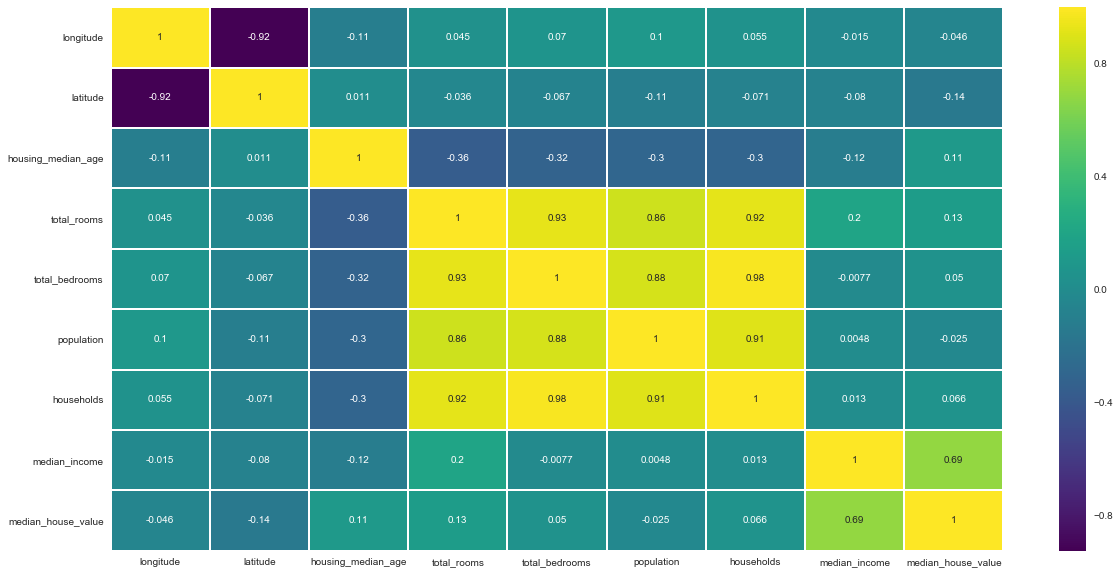

In [8]:
corr_matrix = data.corr()

plt.subplots(figsize=(20,10))

sns.heatmap(corr_matrix, annot=True, linewidths=1, cmap='viridis');

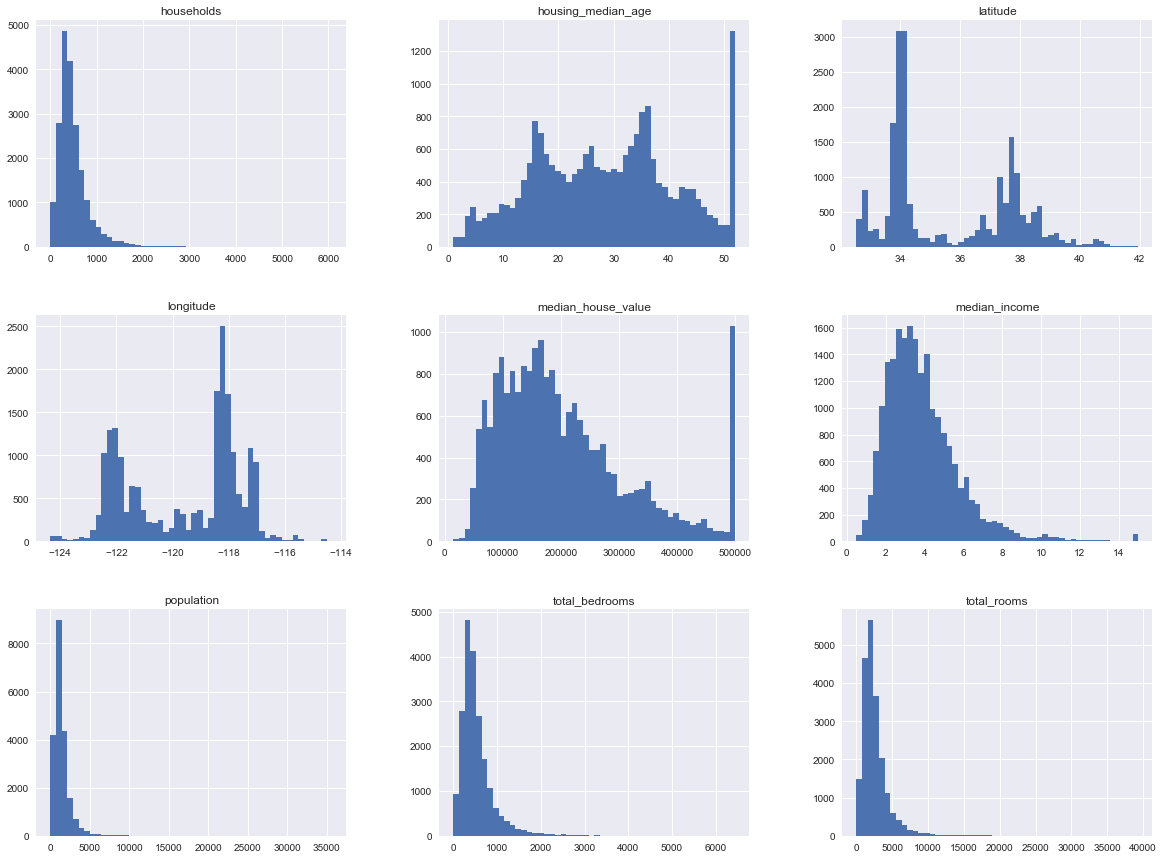

In [9]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
#sns.pairplot(data, hue="ocean_proximity")

In [11]:
data["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

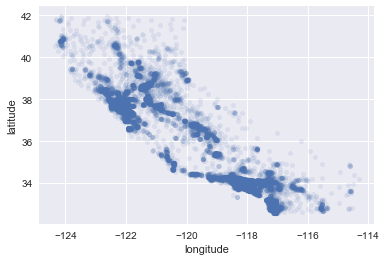

In [12]:
data.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1)

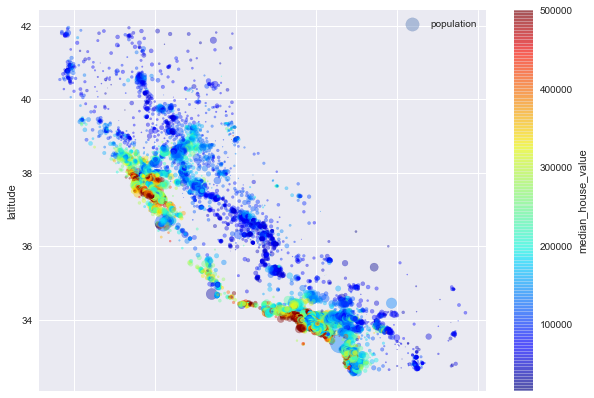

In [13]:
data.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
                s=data["population"]/100,label="population",figsize=(10,7),
                c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True,
)
plt.legend()

## Daten aufbereiten für ML 

### Ergänzen neuer Parameter

def addnewcolumns (newparameter):
    if newparameter == "yes":
        data["bedrooms_per_room"]=data["total_bedrooms"]/data["total_rooms"]
        data["population_per_household"]=data["population"]/data["households"]
        return data
    elif newparameter == "no":
        return data

In [14]:
def adjustinputcolumns (newparameter, longitude,latitude,housing_median_age,total_rooms,population,households,median_income):
    data2 = data
    if newparameter == "yes":
        data2["bedrooms_per_room"]=data2["total_bedrooms"]/data2["total_rooms"]
        data2["population_per_household"]=data2["population"]/data2["households"]
    if longitude == "yes":
        data2 = data2.drop("longitude", axis=1)
    if latitude == "yes":
        data2= data2.drop("latitude", axis=1)
    if housing_median_age == "yes":
        data2= data2.drop("housing_median_age", axis=1)
    if total_rooms == "yes":
        data2= data2.drop("total_rooms", axis=1)
    if population == "yes":
        data2= data2.drop("population", axis=1)       
    if households == "yes":
        data2= data2.drop("households", axis=1)
    if median_income == "yes":
        data2= data2.drop("median_income", axis=1)
    return data2

In [15]:
adjustinputcolumns ("yes","yes","yes","no","no","yes","no","no").head()

,housing_median_age,total_rooms,total_bedrooms,households,median_income,median_house_value,ocean_proximity,bedrooms_per_room,population_per_household
0,41,880,129.0,126,8.3252,452600,NEAR BAY,0.146591,2.555556
1,21,7099,1106.0,1138,8.3014,358500,NEAR BAY,0.155797,2.109842
2,52,1467,190.0,177,7.2574,352100,NEAR BAY,0.129516,2.802260
3,52,1274,235.0,219,5.6431,341300,NEAR BAY,0.184458,2.547945
4,52,1627,280.0,259,3.8462,342200,NEAR BAY,0.172096,2.181467


### Bearbeiten von kategorischen Merkmalen

In [16]:
def categories (categorycolumn,newparameter,longitude,latitude,housing_median_age,total_rooms,population,households,median_income):
    data = adjustinputcolumns (newparameter, longitude,latitude,housing_median_age,total_rooms,population,households,median_income)
    cat_encoded,categories= data[categorycolumn].factorize()
    enc = OneHotEncoder()
    cat1hot=enc.fit_transform(cat_encoded.reshape(-1,1))
    cat1hot_array= cat1hot.toarray()
    category_df = pd.DataFrame(data = cat1hot_array, columns = list(categories))
    datanew = pd.concat([data,category_df],axis=1)
    datanew.drop(categorycolumn,axis = 1,inplace = True)
    return datanew

housing_cat_encoded,housing_categories=data["ocean_proximity"].factorize()
enc = OneHotEncoder()
housing_cat1hot=enc.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat1hot_array= housing_cat1hot.toarray()
new_ocean_df = pd.DataFrame(data = housing_cat1hot_array, columns = list(housing_categories))

data_new = pd.concat([data,new_ocean_df],axis=1)
data_new.drop("ocean_proximity",axis = 1,inplace = True)
data_new.head()

### Umgang mit den Nul-Werten von "total_bedrooms"

In [17]:
# Auffällig ist die Anzahl der Zeilen bei dem Label "total_bedrooms".
#Total_bedrooms mit den Einträgen NaN können von ML nicht gelesen werden
#Daher:

# Option 1: drop all rows with null
# Option 2: drop complete column : housing.drop("total_bedrooms", axis=1) 
#Option 3: ACHTUNG: darf man erst bei den Trainingsdatendurchführen 
#train_set["total_bedrooms"].fillna(train_set["total_bedrooms"].mean(),inplace = True)

In [18]:
def getinputdata (nulloption,categorycolumn,newparameter,longitude,latitude,housing_median_age,total_rooms,population,households,median_income):
    data= categories (categorycolumn,newparameter,longitude,latitude,housing_median_age,total_rooms,population,households,median_income)
    if nulloption == "median":
        return data
    elif nulloption == "deleterows":
        if newparameter != "no":
            datanew = data.dropna(subset=["bedrooms_per_room"])
        elif newparameter == "no":
            datanew = data.dropna(subset=["total_bedrooms"]) 
        return datanew
    elif nulloption == "dropcolumn":
        if newparameter == "yes" and total_rooms =="no":
            datanew= data.drop("total_bedrooms", axis=1) 
            datanew= data.drop("bedrooms_per_room", axis=1) 
        elif newparameter == "yes" and total_rooms =="yes":
            datanew= data.drop("bedrooms_per_room", axis=1)
        elif newparameter == "no":
            datanew= data.drop("total_bedrooms", axis=1) 
        return datanew

### Erstellen der Datensätze für verschiedene Ansätze

Ansätze mit Löschen der Null-Zeilen

Ansatz0 = keine Veränderung der Daten 

In [19]:
Ansatz0 = getinputdata ("deleterows","ocean_proximity","no","no","no","no","no","no","no","no")

Ansatz1 = Neue Parameter mit löschen der Spalten 

In [20]:
Ansatz1 = getinputdata ("deleterows","ocean_proximity","yes","no","no","no","no","no","no","no")

Ansatz2 = Löschen der Koordinaten 

In [21]:
Ansatz2 = getinputdata ("deleterows","ocean_proximity","no","yes","yes","no","no","no","no","no")

### Aufteilen in einen Trainings- und Testdatensatz/ Separieren des Targets

In [22]:
def traintest (data):
    train_set,test_set=train_test_split(data,test_size=0.2,random_state=42) ##aufteilen von test und train
    X_train = train_set.drop("median_house_value", axis=1) # Trainingsdaten ohne Target y "median_house_value"
    y_train = train_set["median_house_value"] # Trainingsdaten nur mit Target y "median_house_value"
    X_test = test_set.drop("median_house_value", axis=1) # Testdaten ohne Target y "median_house_value"
    y_test = test_set["median_house_value"] # Testdaten nur mit Target y "median_house_value"
    return X_train,y_train,X_test,y_test

##doch nicht verwendet, da hier die Skalierung die Spaltenbezeichnung verliert!

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Skalieren der Daten

In [23]:
def scaledata (data,scaling,columnstoscale):
    X_train,y_train,X_test,y_test = traintest (data)
    if scaling == "yes":
        scaler = StandardScaler()
        scaler.fit(X_train.iloc[:,0:columnstoscale])
        X_train.iloc[:,0:columnstoscale] = scaler.transform(X_train.iloc[:,0:columnstoscale])
        X_test.iloc[:,0:columnstoscale] = scaler.transform(X_test.iloc[:,0:columnstoscale])
        return X_train,y_train,X_test,y_test
    elif scaling == "no":
        return X_train,y_train,X_test,y_test

### Durchführen der Models (Lineare Regression/KNR)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model

In [25]:
#result = pd.DataFrame()

In [26]:
def executemodel (model,kstart,kende,data,nameansatz,scaling,columnstoscale):
    X_train,y_train,X_test,y_test = scaledata (data,scaling,columnstoscale)
    if model == "LR":
        result = pd.DataFrame()
        regr = linear_model.LinearRegression()
        # Train the model using the training sets
        regr.fit(X_train, y_train)
        # Make predictions using the training set
        result[nameansatz+"_LR"] = regr.predict(X_test)
        return result,y_test
    elif model == "KNR":
        result = pd.DataFrame()
        for i in range(kstart,kende+1):
            model = KNeighborsRegressor(n_neighbors=i,weights='uniform').fit(X_train, y_train.values) 
            result[nameansatz+"_KNR_"+"k"+str(i)] = model.predict(X_test)
        return result,pd.DataFrame(y_test)

### Ausprobieren verschiedener Input-Daten

Ansätze mit löschen der Null Zeilen:

In [27]:
#Hier werden alle Ergebnisse für den verkürzten (löschen der null Zeilen) gespeichert:
# finalresultsdeletenullrows

- Ansatz0 = keine Veränderung der Daten 
- Ansatz1 = Neue Parameter mit löschen der alten Spalten der Parameter
- Ansatz2 = Löschen der Koordinaten

In [28]:
Ansatz2.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,bedrooms_per_room,population_per_household,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND
0,41,880,129.0,322,126,8.3252,452600,0.146591,2.555556,1.0,0.0,0.0,0.0,0.0
1,21,7099,1106.0,2401,1138,8.3014,358500,0.155797,2.109842,1.0,0.0,0.0,0.0,0.0
2,52,1467,190.0,496,177,7.2574,352100,0.129516,2.802260,1.0,0.0,0.0,0.0,0.0
3,52,1274,235.0,558,219,5.6431,341300,0.184458,2.547945,1.0,0.0,0.0,0.0,0.0
4,52,1627,280.0,565,259,3.8462,342200,0.172096,2.181467,1.0,0.0,0.0,0.0,0.0


Ansatz0 mit Lineare Regression

In [29]:
resultansatz0LR,y_test1 = executemodel("LR",0,0,Ansatz0,"Ansatz0","yes",9)

In [30]:
df = pd.DataFrame(y_test1)
y_test=df.rename(columns={'median_house_value': 'y_test'})
y_test.reset_index(drop=True,inplace=True)

Ansatz0 mit KNR

In [31]:
resultansatz0KNR,y_test2 = executemodel("KNR",3,6,Ansatz0,"Ansatz0","yes",9)

Ansatz1 mit Lineare Regression

In [32]:
resultansatz1LR,ignore = executemodel("LR",0,0,Ansatz1,"Ansatz1","yes",10)

Ansatz1 mit KNR

In [33]:
resultansatz1KNR,ignore = executemodel("KNR",3,6,Ansatz1,"Ansatz1","yes",10)

Ansatz2 mit Lineare Regression

In [34]:
resultansatz2LR,ignore = executemodel("LR",0,0,Ansatz2,"Ansatz2","yes",7)

Ansatz2 mit KNR

In [35]:
resultansatz2KNR,ignore = executemodel("KNR",3,6,Ansatz2,"Ansatz2","yes",7)

Zusammenfügen der Ergebnisse für y:

In [36]:
resultsdeletenullrows = pd.concat([y_test,resultansatz0LR,resultansatz0KNR,resultansatz1LR,resultansatz1KNR,resultansatz2LR,resultansatz2KNR],axis=1)

In [37]:
resultsdeletenullrows.head()

,y_test,Ansatz0_LR,Ansatz0_KNR_k3,Ansatz0_KNR_k4,Ansatz0_KNR_k5,Ansatz0_KNR_k6,Ansatz1_LR,Ansatz1_KNR_k3,Ansatz1_KNR_k4,Ansatz1_KNR_k5,Ansatz1_KNR_k6,Ansatz2_LR,Ansatz2_KNR_k3,Ansatz2_KNR_k4,Ansatz2_KNR_k5,Ansatz2_KNR_k6
0,245800,214008.777609,122466.666667,138725.0,157240.0,150133.333333,214008.777609,133800.000000,158175.0,150300.0,146083.333333,219329.846908,360900.000000,331625.0,316300.0,302133.333333
1,137900,149135.386774,155033.333333,155750.0,153480.0,152966.666667,149135.386774,146900.000000,159550.0,161400.0,167650.000000,137430.255772,128666.666667,136925.0,139240.0,141716.666667
2,218200,203174.150983,199266.666667,206775.0,206280.0,202200.000000,203174.150983,199266.666667,193275.0,200480.0,196033.333333,206124.092615,199266.666667,206775.0,206280.0,202200.000000
3,220800,177845.069783,149633.333333,153650.0,141280.0,144183.333333,177845.069783,210533.333333,206200.0,198100.0,199800.000000,182296.172136,149633.333333,153650.0,154660.0,144183.333333
4,170500,202555.669185,144133.333333,136225.0,139540.0,138083.333333,202555.669185,149833.333333,152025.0,139120.0,140933.333333,174038.649573,116400.000000,114175.0,115200.0,116016.666667


In [38]:
resultsdeletenullrows.shape

(4087, 16)

### Zusammentragen der Ergebnisse

In [39]:
r2=[]
mse=[]
rmse=[]
setindex=["R2","Mittlere quadratische Abweichung (MSE)","Wurzel aus mq Abweichung(RMSE)"]
setcolumns=resultsdeletenullrows.columns.values.tolist()[1:]
table = np.zeros((3,resultsdeletenullrows.shape[1]-1))
for i in range (1,resultsdeletenullrows.shape[1]):
    y=resultsdeletenullrows.iloc[:,0]
    ypre=resultsdeletenullrows.iloc[:,i]
    score=r2_score(y, ypre).round(3)
    r2.append(score)
    score2=mean_squared_error(y,ypre)
    mse.append(score2)
    score3=np.sqrt(score2).round()
    rmse.append(score3)
table[0,:]=r2
table[1,:]=mse
table[2,:]=rmse
resulttable= pd.DataFrame(data=table,columns=setcolumns,index=setindex)

In [40]:
resulttable.T

,R2,Mittlere quadratische Abweichung (MSE),Wurzel aus mq Abweichung(RMSE)
Ansatz0_LR,0.653,4.744471e+09,68880.0
Ansatz0_KNR_k3,0.731,3.678547e+09,60651.0
Ansatz0_KNR_k4,0.744,3.496154e+09,59128.0
Ansatz0_KNR_k5,0.750,3.422493e+09,58502.0
Ansatz0_KNR_k6,0.751,3.409349e+09,58390.0
Ansatz1_LR,0.653,4.744471e+09,68880.0
Ansatz1_KNR_k3,0.709,3.973288e+09,63034.0
Ansatz1_KNR_k4,0.721,3.812353e+09,61744.0
Ansatz1_KNR_k5,0.729,3.712282e+09,60929.0
Ansatz1_KNR_k6,0.732,3.668081e+09,60565.0


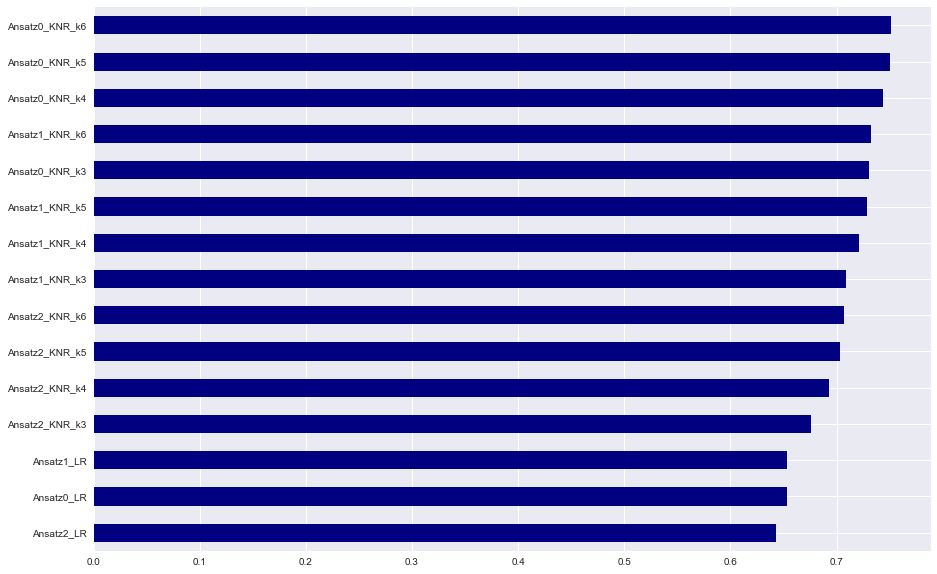

In [54]:
resulttable.loc["R2",:].sort_values(ascending=True).plot.barh(figsize=(15, 10),color="navy")

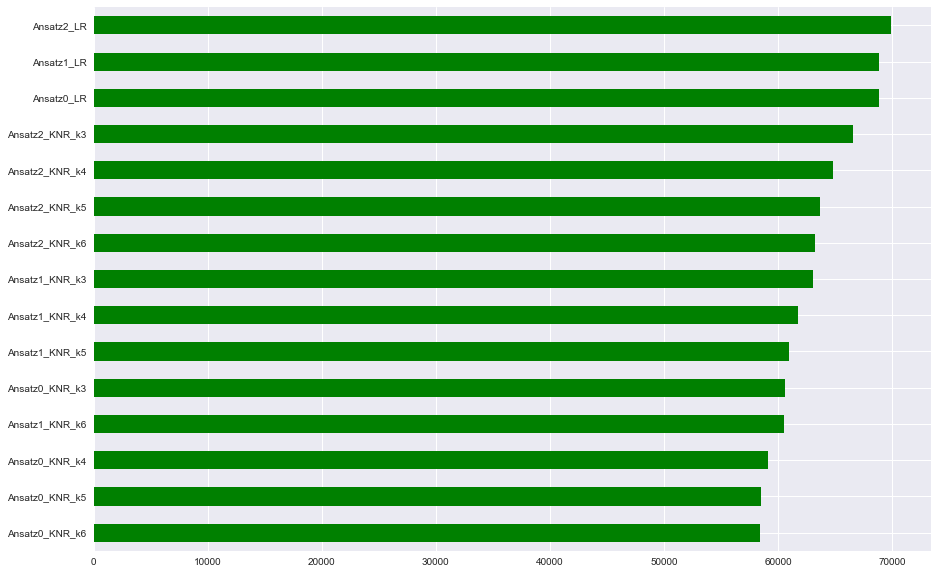

In [56]:
resulttable.loc["Wurzel aus mq Abweichung(RMSE)",:].sort_values(ascending=True).plot.barh(figsize=(15, 10),color="green")

In [ ]:
mse= mean_squared_error(compareyresults["median_house_value"], compareyresults["LR_y_test"])

## Neuer Ansatz: Einführen von Einkommenskategorien

In [ ]:
data_new["income_cat"]=np.ceil(data_new["median_income"]/1.5)
data_new["income_cat"].where(data_new["income_cat"]<5,5,inplace=True)
income_cat_encoded,income_categories=data_new["income_cat"].factorize()